In [1]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from utils import plot_NQueens, plot_evolution

# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [2]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['PDWNnUeauackqmsGB',
 'OBqdKkYyGPwgZULDP',
 'nSodmQoLWfMculclY',
 'lXbfZBtCkVEMqTXsS',
 'fvrVFiZskUQQLnQJr',
 'IkjuyPIyTfBuechcS',
 'lojuRkPMGCTrXTtxV',
 'YWGJBzYWWBJtVkokt',
 'OKNHFCxJLDYFTwJJC',
 'VRZxeMKEZlqKysilf']

In [3]:
def fitness_fn(sample):
    return SequenceMatcher(None, sample, target).quick_ratio()

# test
fitness_fn(init_pop[0])

0.29411764705882354

In [6]:
def select(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    fitness = np.array([fitness_fn(p) for p in population])
    fitness = fitness/sum(fitness)
    choice = []
    for _ in range(r):
        rand = random.random()
        s = 0
        for i in range(len(fitness)):
            if s < rand < s + fitness[i]:
                choice.append(population[i])
                break
            else:
                s += fitness[i]
    return choice


# test
parents = select(2, init_pop, fitness_fn)
parents


['YWGJBzYWWBJtVkokt', 'fvrVFiZskUQQLnQJr']

In [11]:
def recombine(x, y):
    """
    TODO: combine two parents to produce an offspring
    """
    nxt = ''
    for i in range(len(x)):
        if random.random() > 0.5:
            nxt += x[i]
        else:
            nxt += y[i]
    return nxt

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'v BQQFnvYIkQZpcPu'

In [18]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet

    def init_population(self, pop_size):
        # raise NotImplementedError()
        self.pop_size = pop_size
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        # TODO: evaluate how close *sample* is to the target
        correct = 0
        for i in range(len(sample)):
            if sample[i] == target[i]:
                correct += 1
        return correct
    
    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        nxt = []
        for _ in range(len(population)):
            nxt.append(mutate(recombine(*select(2, population, self.fitness)), gene_pool, mutation_rate))
        return nxt
        
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        old = old+new
        old.sort(key=self.fitness,reverse=True)
        return old[:self.pop_size]

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
            if problem.fitness(best) == problem.fitness(problem.target):
                break
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [21]:
# now set up the parameters
ngen = 1200
max_population = 120
mutation_rate = 0.1

sid = 12011517 #TODO:  replace this with your own sid
target = f"Genetic Algorithm by {sid}" 
alphabet = u_case + l_case + [' '] + [str(i) for i in range(10)] # TODO: fix this: what is the search space now?

problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1200,	Best: ddohd0k4RMBCavshhPbL BrSKFHqr,	Fitness=3
Generation: 100/1200,	Best: YeFetic4AlBorBshw by 1201s517,	Fitness=21
Generation: 200/1200,	Best: fenetic4AlBorishm by 1201b517,	Fitness=24
Generation: 300/1200,	Best: Genetic AlBorithm by 1201s517,	Fitness=27
Generation: 400/1200,	Best: Genetic AlBorithm by 1201s517,	Fitness=27
Generation: 500/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 600/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 700/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 800/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 900/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 1000/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28
Generation: 1100/1200,	Best: Genetic Algorithm by 1201b517,	Fitness=28


'Genetic Algorithm by 1201b517'

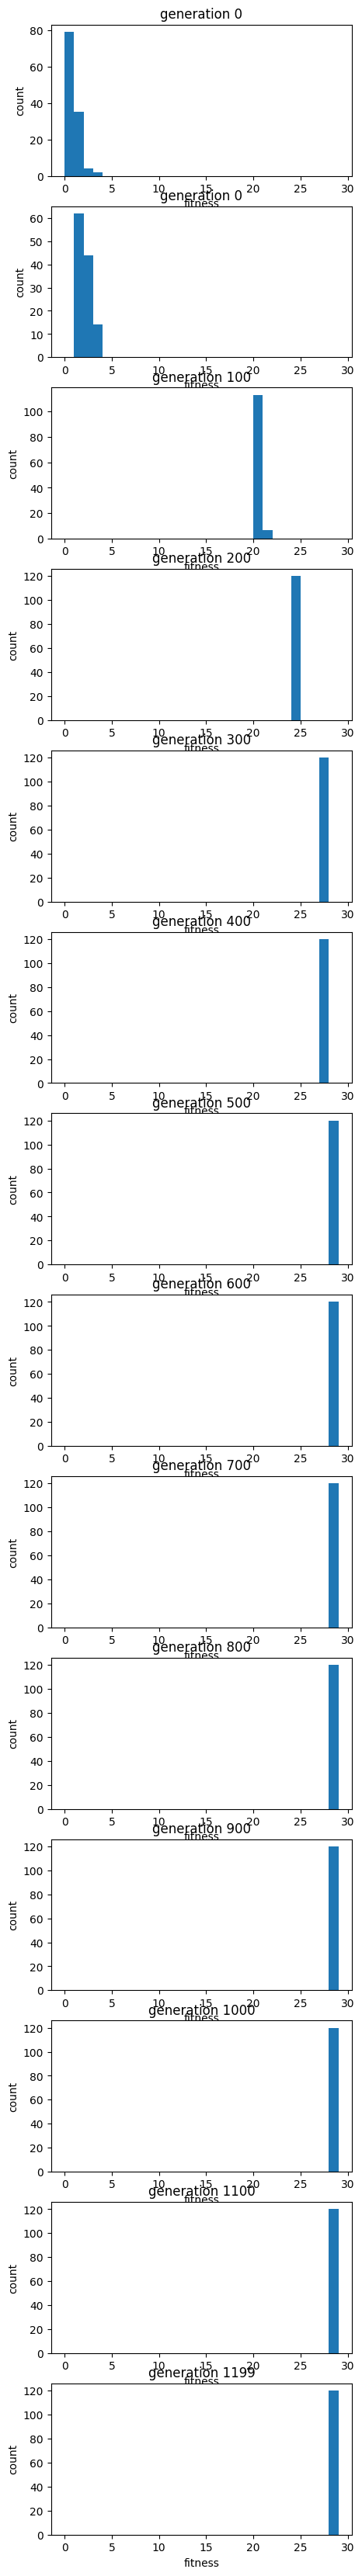

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [22]:
# visualize the evolution of the polulation
bins = np.linspace(0, 29, 30)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [25]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness = n*(n-1)//2  # max number if non-attacking pairs

    def init_population(self, pop_size):
        # TODO:alomost the same as the previous problem.
        self.pop_size = pop_size
        return init_population(pop_size, [str(i) for i in range(self.n)], self.n)

    def fitness(self, queens):
        """
        TODO

        hint: count the non-attacking pairs
        """
        count = 0
        for i in range(len(queens)-1):
            for j in range(i, len(queens)):
                if not self.attack((i, int(queens[i])), (j, int(queens[j]))):
                    count += 1
        return count

    def attack(self, idx1, idx2):
        return abs(idx1[0]-idx2[0]) == abs(idx1[1]-idx2[1]) or idx1[1] == idx2[1]

    def reproduce(self, population, mutation_rate):
        # TODO:alomost the same as the previous problem.
        nxt = []
        for _ in range(len(population)):
            nxt.append(mutate(recombine(*select(2, population, self.fitness)), [str(i) for i in range(self.n)], mutation_rate))
        return nxt

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        old = old+new
        old.sort(key=self.fitness,reverse=True)
        return old[:self.pop_size]

    def __repr__(self):
        return f"{self.n}-Queens Problem"


In [26]:
from utils import plot_NQueens
ngen = 1000
init_size = 120
mutation_rate = 0.15

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)

Generation: 0/1000,	Best: 63071427,	Fitness=27


AttributeError: 'NQueensProblem' object has no attribute 'target'

/Users/lee/GitHub/SUSTECH_UG_Resource/CS303_AI/Lab/Practice7/utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


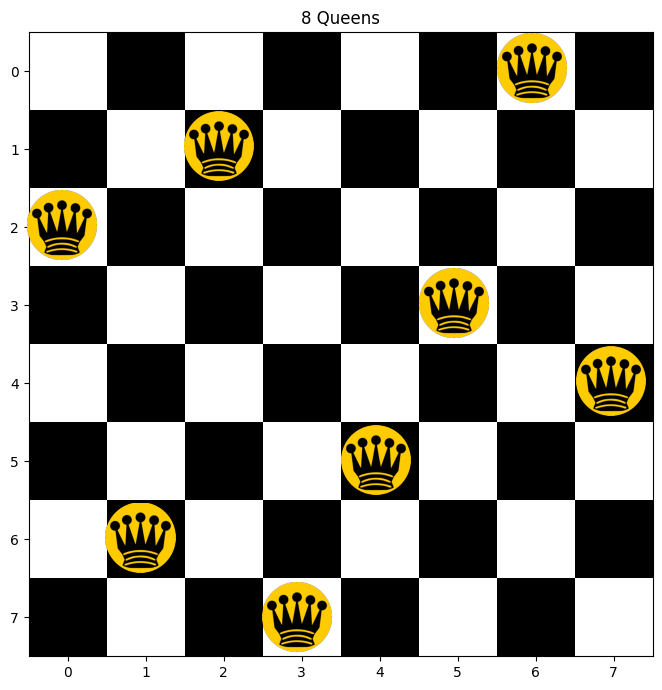

In [ ]:
# Example of how to use this function
#plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens([int(i) for i in solution])

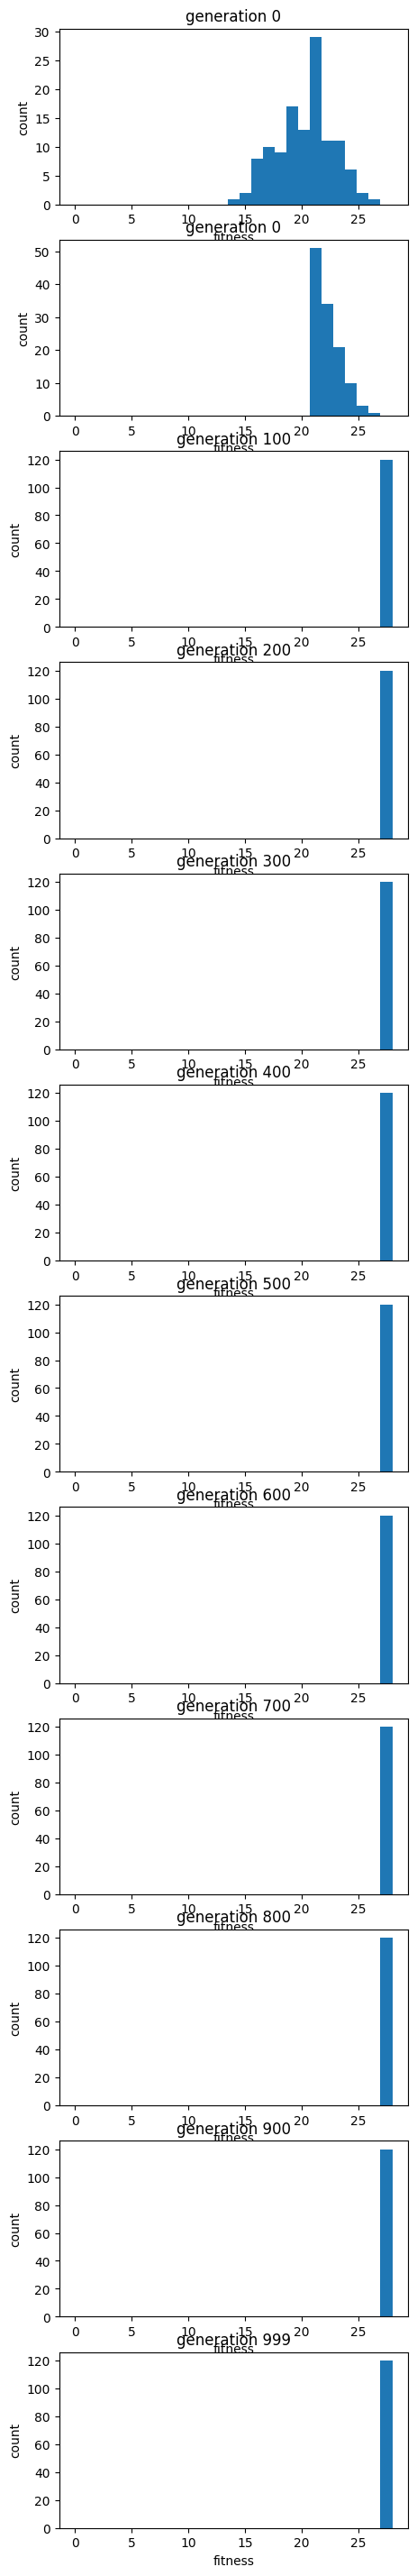

In [ ]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)